In [126]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [127]:
from pathlib import Path


# Configurable parts
SYMBOL = "USDJPY"
SAMPLE_TYPE = "time"
MINUTES = 1
DOLLAR_THRESHOLD = "115009542m"
EVENT_NAME = "CUSUM"
EVENT_THRESHOLD = 2.52e-04

START_DATE = "20210101"
END_DATE = "20241231"

# Build base name
if SAMPLE_TYPE == "dollar":
    SAMPLE_EVENT = f"{DOLLAR_THRESHOLD}-dollar"
    RESAMPLED_NAME = f"{SYMBOL}-{DOLLAR_THRESHOLD}-dollar-{START_DATE}-{END_DATE}"
else:
    SAMPLE_EVENT = f"{MINUTES}m"
    RESAMPLED_NAME = f"{SYMBOL}-{MINUTES}m-{START_DATE}-{END_DATE}"

LABEL_NAME = f"{RESAMPLED_NAME}-{EVENT_NAME}"
# Base directories
BASE_DIR = Path("../data")
RESAMPLED_DIR = BASE_DIR / "resampled"
LABEL_DIR = BASE_DIR / "labels"
PROCESSED_DIR = BASE_DIR / "processed"
NORMALIZED_DIR = BASE_DIR / "normalized"
DIRECTION_LABEL_DIR = BASE_DIR / "direction_labels"
PREDICTION_DIR = BASE_DIR / "predictions"

# Final paths
PROCESSED_FILE_PATH = PROCESSED_DIR / f"{RESAMPLED_NAME}-processed.pkl"
NORMALIZED_FILE_PATH = NORMALIZED_DIR / f"{RESAMPLED_NAME}-normalized.pkl"
DIRECTION_LABEL_FILE_PATH = DIRECTION_LABEL_DIR / f"{RESAMPLED_NAME}-{EVENT_NAME}.pkl"
PREDICTION_FILE_PATH = PREDICTION_DIR / f"{RESAMPLED_NAME}-{EVENT_NAME}.pkl"

In [128]:
SEQUENCE_LENGTH = 120
TIME_COLS = [
    # 'timestamp',
    "hour",
    "dow",
    "dom",
    "month",
    # "open",
    # "high",
    # "low",
    # "close",
]
FEATURES_COLS = [
    "hour_cos",
    "dow_cos",
    "dom_cos",
    "month_cos",
    "close_log_return",
    "ret_mean_5",
    "ret_mean_10",
    "ret_mean_15",
    "ret_mean_20",
    # "log_volume",
    "ema5_slope",
    "ema20_slope",
    "ema50_slope",
    "ema100_slope",
    "atr14",
    "atr25",
    "atr50",
    "rsi14",
    "rsi25",
    "rsi50",
    # "adx14",
    # "plus_di14",
    # "minus_di14",
    "close_to_atr",
    "macd_diff",
    "bb_width",
    "bb_position",
    "donchian_width",
]

TARGET_COL = "bin_class"

In [129]:
MODEL_NAME = "simple_transformer"
V_NUM = 7
MODEL_PATH = f'../lightning_logs/{MODEL_NAME}-{SAMPLE_EVENT}-{EVENT_NAME}/version_{V_NUM}/checkpoints/best_checkpoint.ckpt'

In [130]:
SIDE_NAME = 'transformer_sides'

META_LABEL_DIR = BASE_DIR / "meta_labels"
META_LABEL_DIR.mkdir(parents=True, exist_ok=True)
META_LABEL_FILE_PATH = META_LABEL_DIR / f"{RESAMPLED_NAME}-{EVENT_NAME}-{SIDE_NAME}.pkl"

In [131]:
%%time
df = pd.read_pickle(NORMALIZED_FILE_PATH)
labels_df = pd.read_pickle(DIRECTION_LABEL_FILE_PATH)

CPU times: user 1.27 ms, sys: 84.5 ms, total: 85.8 ms
Wall time: 86.9 ms


In [132]:
missing = labels_df.index.difference(df.index)
missing

DatetimeIndex([], dtype='datetime64[ns]', name='timestamp', freq=None)

### Load Model

In [133]:
from models.classification.t2v_transformer_model import T2VTransformerModule
from models.classification.simple_transformer_model import SimpleTransformerModule

In [134]:
model = SimpleTransformerModule.load_from_checkpoint(MODEL_PATH)


## Get Side from Trained Model

In [135]:
# features = df[TIME_COLS + FEATURES_COLS]
features = df[FEATURES_COLS]

In [136]:
features.shape

(1487207, 24)

In [137]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm


def extract_sequences(data: pd.DataFrame, t_events, lookback: int):
    """Extract valid sequences and events for batch processing."""
    sequences, valid_events = [], []
    data_values, data_index = data.values.astype(np.float32), data.index
    
    for t in t_events:
        try:
            if t in data_index:
                end_loc = data_index.get_loc(t)
                start_loc = end_loc - lookback
                if start_loc >= 0:
                    seq = data_values[start_loc:end_loc]
                    if len(seq) == lookback:
                        sequences.append(seq)
                        valid_events.append(t)
        except:
            continue
    
    return (np.stack(sequences), valid_events) if sequences else (None, [])

def get_side_from_model_batch(model, data: pd.DataFrame, labels: pd.DataFrame, 
                             lookback: int = 24, device: str = 'cpu', batch_size: int = 64):
    """Batch process model predictions for time series events."""
    model.eval().to(device)
    
    sequences, valid_events = extract_sequences(data, labels.index, lookback)
    if sequences is None:
        return pd.DataFrame()
    
    predictions, probabilities = [], []
    n_batches = (len(sequences) + batch_size - 1) // batch_size
    
    for i in tqdm(range(0, len(sequences), batch_size), total=n_batches, desc="Processing batches"):
        batch = sequences[i:i + batch_size]
        x_tensor = torch.tensor(batch, device=device)
        with torch.no_grad():
            logits = model(x_tensor)
            probs = torch.softmax(logits, dim=1)
            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            probabilities.extend(probs.cpu().numpy())

    result_df = pd.DataFrame(probabilities, index=valid_events)
    result_df.columns = [f'prob_{i}' for i in range(len(result_df.columns))]
    result_df['prediction'] = predictions
    result_df['side'] = result_df['prediction'] - 1
    
    return result_df

In [138]:
%%time
predictions = get_side_from_model_batch(model=model, data=features,labels=labels_df, lookback=SEQUENCE_LENGTH, device='mps', batch_size=1024)
print(predictions.side.value_counts())
print(predictions.isna().sum())

Processing batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:07<00:00, 27.85it/s]


side
-1    92919
 0    67173
 1    39013
Name: count, dtype: int64
prob_0        0
prob_1        0
prob_2        0
prediction    0
side          0
dtype: int64
CPU times: user 1.33 s, sys: 513 ms, total: 1.84 s
Wall time: 8.06 s


In [139]:
labels_df = labels_df.join(predictions)

In [140]:
labels_df.shape

(199121, 10)

In [141]:
labels_df.isna().sum()

t1             0
trgt           0
ret            0
bin            0
bin_class      0
prob_0        16
prob_1        16
prob_2        16
prediction    16
side          16
dtype: int64

In [142]:
labels_df = labels_df.dropna().copy()
labels_df.head()

,t1,trgt,ret,bin,bin_class,prob_0,prob_1,prob_2,prediction,side
timestamp,,,,,,,,,,
2021-01-04 01:45:00,2021-01-04 01:47:00,0.000128,0.000146,1.0,2.0,0.471331,0.101406,0.427263,0.0,-1.0
2021-01-04 01:50:00,2021-01-04 01:54:00,0.000130,0.000213,1.0,2.0,0.362515,0.285089,0.352397,0.0,-1.0
2021-01-04 02:01:00,2021-01-04 02:02:00,0.000123,0.000170,1.0,2.0,0.368877,0.245689,0.385434,2.0,1.0
2021-01-04 02:52:00,2021-01-04 02:58:00,0.000123,-0.000150,-1.0,0.0,0.423847,0.160072,0.416081,0.0,-1.0
2021-01-04 07:42:00,2021-01-04 07:46:00,0.000127,-0.000369,-1.0,0.0,0.573498,0.006515,0.419987,0.0,-1.0


In [143]:
labels_df['confidence'] = labels_df.apply(
    lambda x: x[f"prob_{int(x['prediction'])}"], axis=1
)


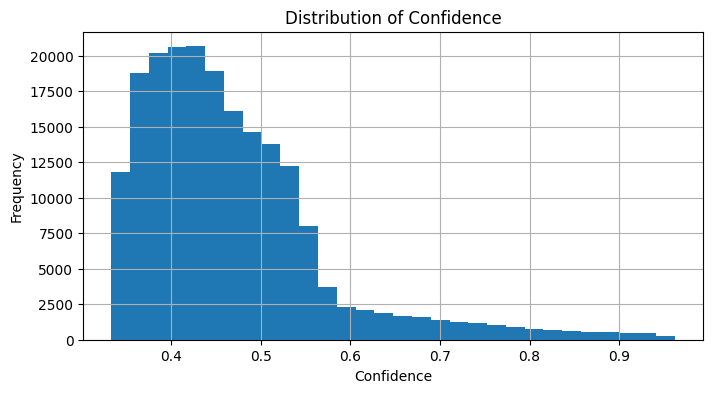

In [144]:
labels_df['confidence'].hist(bins=30, figsize=(8,4))
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.title("Distribution of Confidence")
plt.show()


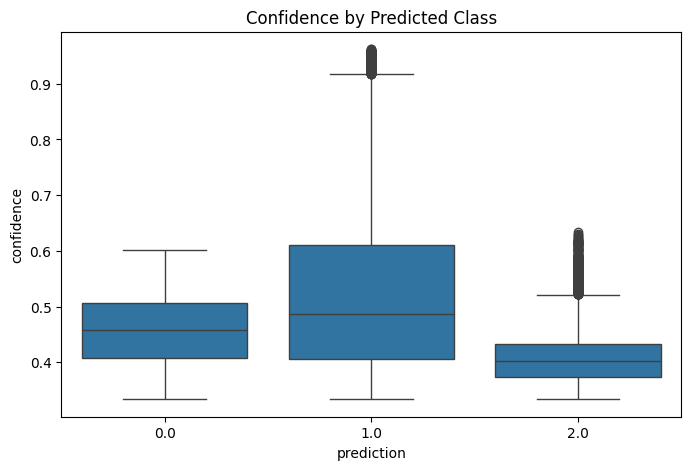

In [145]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.boxplot(x="prediction", y="confidence", data=labels_df)
plt.title("Confidence by Predicted Class")
plt.show()


In [146]:
labels_df['bin_class'].value_counts(normalize=True)


bin_class
2.0    0.379041
0.0    0.368102
1.0    0.252857
Name: proportion, dtype: float64

In [147]:
labels_df = labels_df.dropna()

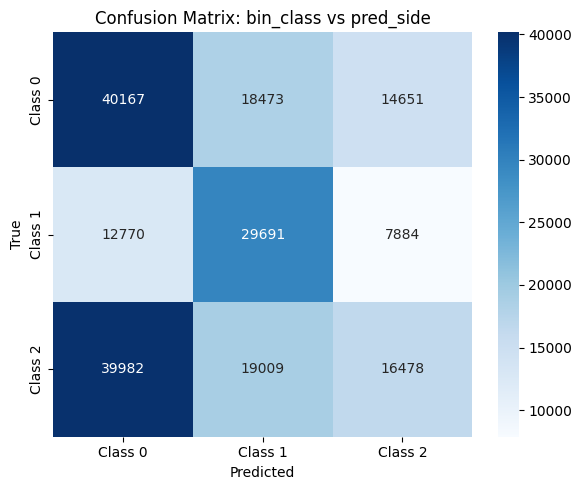

In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 將類別轉為整數型別
y_true = labels_df["bin_class"].astype(int)
y_pred = labels_df["prediction"].astype(int)

# 計算混淆矩陣
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
labels = ["Class 0", "Class 1", "Class 2"]

# 繪圖
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix: bin_class vs pred_side")
plt.tight_layout()
plt.show()


In [149]:
labels_df.to_pickle(PREDICTION_FILE_PATH)

In [150]:
labels_df.columns

Index(['t1', 'trgt', 'ret', 'bin', 'bin_class', 'prob_0', 'prob_1', 'prob_2',
       'prediction', 'side', 'confidence'],
      dtype='object')